<a href="https://colab.research.google.com/github/dohkim/tourMega_assignment/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re

from IPython.core.display import clear_output
from random import randint
from requests import get
from time import sleep
from time import time
start_time = time()

from warnings import warn

# **Scrape Information**

In [102]:
requests = 0
max_page = 70
target = "https://www.yelp.com/search?find_desc=Landmarks%20%26%20Historical%20Buildings&find_loc=San%20Jose%2C%20CA&start="

names = []
details = []
ratings = []
reviews = []
address = []
phones = []

for page in range(0,max_page,10):
  url = target+str(page)
  response = get(url)    
  sleep(randint(8,15))

  #to get the progress status
  requests += 1
  elapsed_time = time() - start_time
  print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
  clear_output(wait = True)
  if response.status_code != 200:
    warn('Request: {}; Status code: {}'.format(requests, response.status_code))
    
  html_soup = BeautifulSoup(response.text, 'html.parser')

  containers = html_soup.find_all('div',{'class': 'container__09f24__21w3G'})
  for container in containers:  
    
    pName = container.h4.get_text(strip=True)
    pName = re.sub(r'^[\d.\s]+', '', pName)
    names.append(pName)
    
    try:
      info = container.select_one('[class*="secondaryAttributes"]').get_text(separator=',').split(',')
    except:
      # in case of None
      info=""
    
    if re.match(r"^(\([0-9]{3}\) ?|[0-9]{3}-)[0-9]{3}-[0-9]{4}$", info[0]):
      pNumber=info[0]
      pAddress=", ".join(info[1:])
    else:
      pNumber=""
      pAddress=", ".join(info)
    
    phones.append(pNumber)
    address.append(pAddress)
    
    try:
      starCount = container.select_one('[class*="i-stars"]')['aria-label']
    except:
      # in case of None
      starCount = "" 
    starCount=re.sub(r'[^\d.]', '',starCount)
    ratings.append(starCount)

    try:
      numReview =  container.select_one('[class*="reviewCount"]').get_text()
    except:
      # in case of None
      numReview = ""
    reviews.append(numReview)
    
    category = container.select_one('[class*="priceCategory"]').get_text(separator=',')
    re.sub(r' ',"",category)    
    details.append(category)  

Request:7; Frequency: 0.08171559177598832 requests/s


# **Format the data into a data frame**

In [214]:
df = pd.DataFrame({
    'Name of Place' : names,
    'Details' : details,
    'Rating' : ratings,
    'Number of Reviews' : reviews,
    'Address' : address,
    'Phone Number' : phones    

})
df['Number of Reviews'] = df['Number of Reviews'].replace('', 0 ,regex=True)
df['Number of Reviews'] = df['Number of Reviews'].astype(int)

In [211]:
df.head(10)

,Name of Place,Details,Rating,Number of Reviews,Address,Phone Number
0,History Park,"Landmarks & Historical Buildings,, ,Venues & E...",4,97,"635 Phelan Ave, East San Jose",(408) 287-2290
1,Ainsley House,"Landmarks & Historical Buildings,, ,Museums,, ...",5,6,300 Grant St,(408) 866-2119
2,Circle of Palms,Landmarks & Historical Buildings,4.5,3,"179 S Market St, Downtown",
3,Communications Hill Grand Staircase,Landmarks & Historical Buildings,5,8,"399 Mullinix Way, Fairgrounds",
4,Peralta Adobe And Fallon House,Landmarks & Historical Buildings,3.5,6,"175 W Saint John St, Downtown",(408) 287-2290
5,James Lick Mansion,Landmarks & Historical Buildings,5,1,"550 Mansion Park Dr, North San Jose",
6,Agnews Historic Park,"Landmarks & Historical Buildings,, ,Parks",5,3,"4030 Lafayette St, North San Jose",(408) 615-2200
7,Mission Santa Clara de Asis,"Churches,, ,Landmarks & Historical Buildings",4.5,54,500 El Camino Real,(408) 554-4023
8,San Jose Armory,Landmarks & Historical Buildings,4,1,"240 N 2nd St, Downtown",(415) 255-5555
9,César Chávez Family Home,Landmarks & Historical Buildings,3,2,"53 Scharff Ave, North Valley",


## **new data frame for each rating range (0-1, 1-2, 2-3, 3-4, 4-5). Then sort the data in each frame by descending number of reviews.**

In [217]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
rating_column = df['Rating']
for i in range(0,5):
  globals()[f"df{i+1}"] = df.loc[(rating_column>=i) & (rating_column <i+1)].sort_values('Rating',ascending=False)

In [218]:
df4

,Name of Place,Details,Rating,Number of Reviews,Address,Phone Number
4,Peralta Adobe And Fallon House,Landmarks & Historical Buildings,3.5,6,"175 W Saint John St, Downtown",(408) 287-2290
12,Winchester Mystery House,"Landmarks & Historical Buildings,, ,Museums,, ...",3.5,1940,"525 S Winchester Blvd, West San Jose",(408) 247-2000
24,Gilroy Hot Springs,"Hiking,, ,Landmarks & Historical Buildings",3.5,3,9824 Gilroy Hot Springs Rd,
30,Old Mission San Jose & Museum,"Museums,, ,Landmarks & Historical Buildings",3.5,48,43300 Mission Blvd,(510) 657-1797
52,HP Garage,Landmarks & Historical Buildings,3.5,12,367 Addison Ave,
9,César Chávez Family Home,Landmarks & Historical Buildings,3.0,2,"53 Scharff Ave, North Valley",
10,W.W. Cozzens House - San Jose Historical Landm...,Landmarks & Historical Buildings,3.0,1,"1195 Minnesota Ave, Willow Glen",
15,Agnew Depot,Landmarks & Historical Buildings,3.0,1,4185 Bassett St,
17,Paul and May Clark Home - San Jose Historical ...,Landmarks & Historical Buildings,3.0,1,"1147 Minnesota Ave, Willow Glen",
22,First Honeybees in California,Landmarks & Historical Buildings,3.0,1,"1701 Airport Blvd, North San Jose",


# **Word Cloud**


In [196]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [209]:
def show_word(content):

  comment_words = ''
  stopwords = set(STOPWORDS)
  for val in content.Details:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
          
    comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
    
  # plot the WordCloud image                       
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
    
  plt.show()

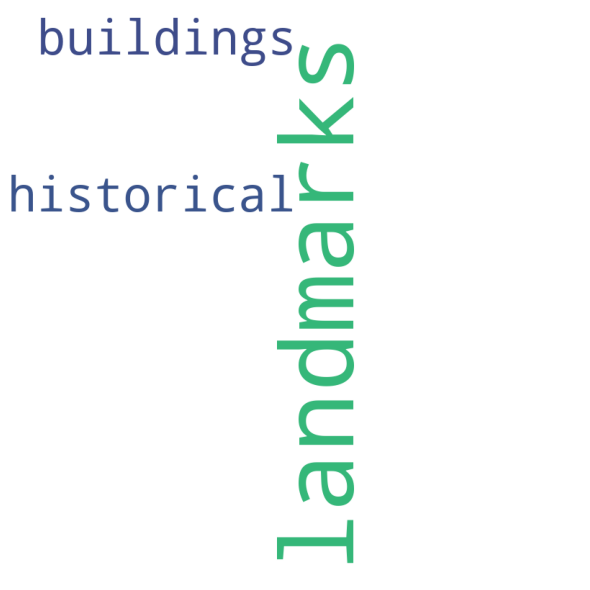

In [210]:
show_word(df.iloc[[3]])